In [1]:
import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

We start with a linear model of the system

In [2]:
G = scipy.signal.lti([2], [1, 2, 1])

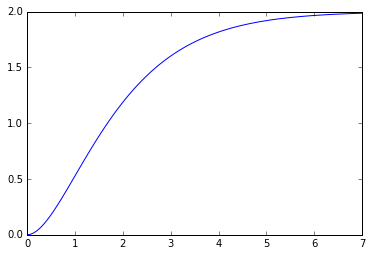

In [3]:
plt.plot(*G.step())

In [4]:
M = 10  # Control horizon
P = 20  # Prediction horizon

In [5]:
DeltaT = 0.5  # Sampling rate

In [6]:
tcontinuous = numpy.linspace(0, DeltaT*P, 1000)  # some closely spaced time points
tpredict = numpy.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon

In [7]:
u = numpy.ones(M)
r = numpy.ones(P)

In [8]:
tau_c = 0.5
r = 1 - numpy.exp(-tpredict/tau_c)

In [9]:
x0 = numpy.zeros(G.A.shape[0])

In [10]:
def extend(u):
    return numpy.concatenate([u, numpy.repeat(u[-1], P-M)])

In [11]:
def prediction(u, t=tpredict, x0=x0):
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

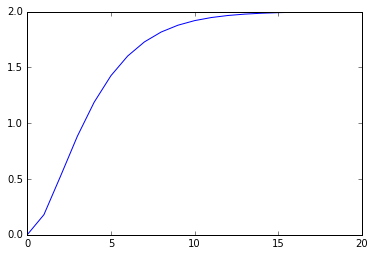

In [12]:
plt.plot(prediction(extend(u)))

In [13]:
def objective(u, x0=x0):
    y = prediction(extend(u))
    umag = numpy.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(numpy.abs(numpy.diff(u)))
    strongfinish = numpy.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0*constraintpenalty + 10*movepenalty + 100*strongfinish

In [14]:
objective(u)

112.28194855677653

Now we figure out a set of moves which will minimise our objective function

In [15]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun

1.2109589921821535

Resample the discrete output to continuous time

In [16]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]

Plot the move plan and the output. Notice that we are getting exactly the output we want at the sampling times.

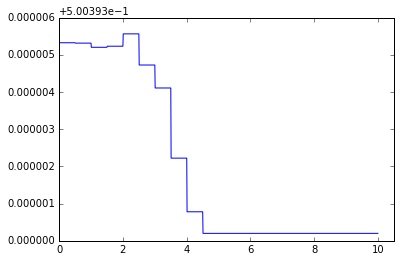

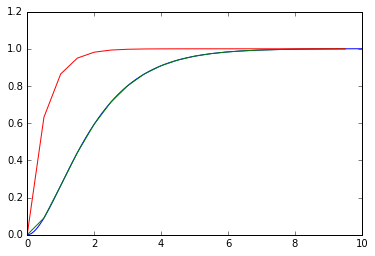

In [17]:
plt.figure()
plt.plot(tcontinuous, ucont)
plt.xlim([0, DeltaT*(P+1)])
plt.figure()
plt.plot(tcontinuous, prediction(ucont, tcontinuous), 
         tpredict, prediction(extend(uopt)),
         tpredict, r,
         )